In [1]:
%load_ext autoreload
%autoreload 2

In [457]:
from common import (
    get_starting_df,
    find_sessions,
    # add_regression_target,
    add_target,
    # calc_y,
    add_fold,
)
import polars as pl
import gymnasium as gym
# from IPython import display
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import lightgbm
import matplotlib.pyplot as plt

In [490]:
df = (
    get_starting_df()
    .pipe(find_sessions)
    .pipe(add_target)
)

In [491]:
df.pipe(add_fold).write_parquet("with_fold.parquest")

In [492]:
del df

In [493]:
df = pl.read_parquet("with_fold.parquest")

In [494]:
df.shape

(99999, 16)

In [495]:
df['agg_session'].max()

2289

In [496]:
df['fold'].value_counts()

fold,count
i32,u32
0,25023
2,24986
3,25004
1,24986


In [497]:
vc = df['target'].value_counts()

In [498]:
vc

target,count
bool,u32
false,67819
true,32180


In [499]:
vc.filter(~pl.col('target'))['count'] / vc['count'].sum()

count
f64
0.678197


In [500]:
df.head()

user_id,timestamp,user_diff,user,ts_diff,C_new_session_mark,cont_session,new_session_mark,agg_session,U_seq,A_seq,C_seq,A_in_U,C_in_A,target,fold
str,datetime[μs],bool,u32,i64,bool,u32,bool,u32,u32,u32,u32,u32,u32,bool,i32
"""4d5835cc2a82e278e6000028""",2015-01-05 03:04:02,true,1,0,true,1,true,1,1,1,1,1,1,false,2
"""4d5835cc2a82e278e6000028""",2015-01-05 03:04:53,false,1,51,false,1,false,1,2,2,2,2,2,false,2
"""4d5835cc2a82e278e6000028""",2015-01-05 03:05:45,false,1,52,false,1,false,1,3,3,3,3,3,false,2
"""4d5835cc2a82e278e6000028""",2015-01-05 03:06:10,false,1,25,false,1,false,1,4,4,4,4,4,false,2
"""4d5835cc2a82e278e6000028""",2015-01-05 03:06:25,false,1,15,false,1,false,1,5,5,5,5,5,false,2


In [501]:
df.with_columns(num_cont_session=pl.col('cont_session').n_unique().over('user'))['num_cont_session'].plot.hist()

:Histogram   [num_cont_session]   (num_cont_session_count)

In [502]:
df.with_columns(num_agg_session=pl.col('agg_session').n_unique().over('user'))['num_agg_session'].plot.hist()

:Histogram   [num_agg_session]   (num_agg_session_count)

In [503]:
df.with_columns(num_cont_in_agg_session=pl.col('cont_session').n_unique().over('agg_session'))['num_cont_in_agg_session'].plot.hist()

:Histogram   [num_cont_in_agg_session]   (num_cont_in_agg_session_count)

In [504]:
def add_aggregated_session_features(df):
    """A - aggregated session"""
    over = "agg_session"
    return (
        df
        .sort(['user_id','timestamp'])
        .with_columns(
            ((pl.col('timestamp') - pl.col("timestamp").min().over(over)).dt.total_seconds()).alias('since_start_of_session')
        )
        .with_columns(diff_from_prev = pl.col('timestamp').diff().dt.total_seconds().fill_null(0))
        .with_columns(diff_from_prev=pl.when(pl.col("new_session_mark"))
                        .then(0)
                        .otherwise(pl.col("diff_from_prev"))
                     )
        .with_columns(lag1_diff_from_prev = pl.col('diff_from_prev').shift().fill_null(0))
        .with_columns(lag1_diff_from_prev=pl.when(pl.col("new_session_mark"))
                        .then(0)
                        .otherwise(pl.col("lag1_diff_from_prev"))
                     )
        .with_columns(
            avg_per_hit=pl.col('since_start_of_session') / pl.col('A_seq')
        )
        .with_columns(
            pl.col('avg_per_hit').shift().fill_null(0).alias('lag1_avg_per_hit')      
        )
        .with_columns(pl.col('timestamp').min().over(over).alias('session_start_time'))
        .with_columns((pl.col('session_start_time') - pl.col('session_start_time').dt.date()).dt.total_minutes().alias('time_in_min_session_start'))
        .with_columns(rolling_var_3_diff_from_prev=pl.col('diff_from_prev').rolling_var(window_size=3).over(over).fill_null(0))
        .with_columns(rolling_var_5_diff_from_prev=pl.col('diff_from_prev').rolling_var(window_size=5).over(over).fill_null(0))
        .with_columns(rolling_var_3_avg_per_hit=pl.col('avg_per_hit').rolling_var(window_size=3).over(over).fill_null(0))
        .with_columns(rolling_var_5_avg_per_hit=pl.col('avg_per_hit').rolling_var(window_size=5).over(over).fill_null(0))
        .with_columns(rolling_var_7_avg_per_hit=pl.col('avg_per_hit').rolling_var(window_size=7).over(over).fill_null(0))
    )

In [505]:
df.pipe(add_aggregated_session_features).head()

user_id,timestamp,user_diff,user,ts_diff,C_new_session_mark,cont_session,new_session_mark,agg_session,U_seq,A_seq,C_seq,A_in_U,C_in_A,target,fold,since_start_of_session,diff_from_prev,lag1_diff_from_prev,avg_per_hit,lag1_avg_per_hit,session_start_time,time_in_min_session_start,rolling_var_3_diff_from_prev,rolling_var_5_diff_from_prev,rolling_var_3_avg_per_hit,rolling_var_5_avg_per_hit,rolling_var_7_avg_per_hit
str,datetime[μs],bool,u32,i64,bool,u32,bool,u32,u32,u32,u32,u32,u32,bool,i32,i64,i64,i64,f64,f64,datetime[μs],i64,f64,f64,f64,f64,f64
"""4d5835cc2a82e278e6000028""",2015-01-05 03:04:02,true,1,0,true,1,true,1,1,1,1,1,1,false,2,0,0,0,0.0,0.0,2015-01-05 03:04:02,184,0.0,0.0,0.0,0.0,0.0
"""4d5835cc2a82e278e6000028""",2015-01-05 03:04:53,false,1,51,false,1,false,1,2,2,2,2,2,false,2,51,51,0,25.5,0.0,2015-01-05 03:04:02,184,0.0,0.0,0.0,0.0,0.0
"""4d5835cc2a82e278e6000028""",2015-01-05 03:05:45,false,1,52,false,1,false,1,3,3,3,3,3,false,2,103,52,51,34.333333,25.5,2015-01-05 03:04:02,184,884.333333,0.0,317.842593,0.0,0.0
"""4d5835cc2a82e278e6000028""",2015-01-05 03:06:10,false,1,25,false,1,false,1,4,4,4,4,4,false,2,128,25,52,32.0,34.333333,2015-01-05 03:04:02,184,234.333333,0.0,20.953704,0.0,0.0
"""4d5835cc2a82e278e6000028""",2015-01-05 03:06:25,false,1,15,false,1,false,1,5,5,5,5,5,false,2,143,15,25,28.6,32.0,2015-01-05 03:04:02,184,366.333333,516.3,8.312593,192.537556,0.0


In [506]:
def add_current_task_features(df):
    """T - task"""
    return (
        df
        .with_columns((pl.col('timestamp') - pl.col('timestamp').dt.date()).dt.total_minutes().alias('time_in_min'))
        .with_columns((pl.col('timestamp').dt.date()).dt.weekday().alias('weekday'))
        # .to_dummies('weekday') # relevant at least when I try LR
    )

In [507]:
df.pipe(add_current_task_features).head()

user_id,timestamp,user_diff,user,ts_diff,C_new_session_mark,cont_session,new_session_mark,agg_session,U_seq,A_seq,C_seq,A_in_U,C_in_A,target,fold,time_in_min,weekday
str,datetime[μs],bool,u32,i64,bool,u32,bool,u32,u32,u32,u32,u32,u32,bool,i32,i64,i8
"""4d5835cc2a82e278e6000028""",2015-01-05 03:04:02,true,1,0,true,1,true,1,1,1,1,1,1,false,2,184,1
"""4d5835cc2a82e278e6000028""",2015-01-05 03:04:53,false,1,51,false,1,false,1,2,2,2,2,2,false,2,184,1
"""4d5835cc2a82e278e6000028""",2015-01-05 03:05:45,false,1,52,false,1,false,1,3,3,3,3,3,false,2,185,1
"""4d5835cc2a82e278e6000028""",2015-01-05 03:06:10,false,1,25,false,1,false,1,4,4,4,4,4,false,2,186,1
"""4d5835cc2a82e278e6000028""",2015-01-05 03:06:25,false,1,15,false,1,false,1,5,5,5,5,5,false,2,186,1


In [508]:
def add_user_features(df):
    """U - user/worker"""
    return (
        df
        .sort(['user_id','timestamp'])
        .with_columns(
            ((pl.col('timestamp') - pl.col("timestamp").min().over("user")).dt.total_seconds()).alias('U_since_start_of_user')
        )
        .with_columns(U_diff_from_prev = pl.col('timestamp').diff().dt.total_seconds().fill_null(0))
        .with_columns(U_diff_from_prev=pl.when(pl.col("user_diff"))
                        .then(0)
                        .otherwise(pl.col("U_diff_from_prev"))
                     )
        .with_columns(U_lag1_diff_from_prev = pl.col('U_diff_from_prev').shift().fill_null(0))
        .with_columns(U_lag1_diff_from_prev=pl.when(pl.col("user_diff"))
                        .then(0)
                        .otherwise(pl.col("U_lag1_diff_from_prev"))
                     )
        .with_columns(
            U_avg_per_hit=pl.col('U_since_start_of_user') / pl.col('U_seq')
        )
        .with_columns(
            pl.col('U_avg_per_hit').shift().fill_null(0).alias('U_lag1_avg_per_hit')      
        )
        .with_columns(pl.col('timestamp').min().over('user').alias('user_start_time'))
        .with_columns((pl.col('user_start_time') - pl.col('user_start_time').dt.date()).dt.total_minutes().alias('U_time_in_min_user_start'))
        .with_columns(U_rolling_var_3_diff_from_prev=pl.col('U_diff_from_prev').rolling_var(window_size=3).over('user').fill_null(0))
        .with_columns(U_rolling_var_5_diff_from_prev=pl.col('U_diff_from_prev').rolling_var(window_size=5).over('user').fill_null(0))
        .with_columns(U_rolling_var_3_avg_per_hit=pl.col('U_avg_per_hit').rolling_var(window_size=3).over('user').fill_null(0))
        .with_columns(U_rolling_var_5_avg_per_hit=pl.col('U_avg_per_hit').rolling_var(window_size=5).over('user').fill_null(0))
        .with_columns(U_rolling_var_7_avg_per_hit=pl.col('U_avg_per_hit').rolling_var(window_size=7).over('user').fill_null(0))        
    )

In [509]:
df.pipe(add_user_features).head()

user_id,timestamp,user_diff,user,ts_diff,C_new_session_mark,cont_session,new_session_mark,agg_session,U_seq,A_seq,C_seq,A_in_U,C_in_A,target,fold,U_since_start_of_user,U_diff_from_prev,U_lag1_diff_from_prev,U_avg_per_hit,U_lag1_avg_per_hit,user_start_time,U_time_in_min_user_start,U_rolling_var_3_diff_from_prev,U_rolling_var_5_diff_from_prev,U_rolling_var_3_avg_per_hit,U_rolling_var_5_avg_per_hit,U_rolling_var_7_avg_per_hit
str,datetime[μs],bool,u32,i64,bool,u32,bool,u32,u32,u32,u32,u32,u32,bool,i32,i64,i64,i64,f64,f64,datetime[μs],i64,f64,f64,f64,f64,f64
"""4d5835cc2a82e278e6000028""",2015-01-05 03:04:02,true,1,0,true,1,true,1,1,1,1,1,1,false,2,0,0,0,0.0,0.0,2015-01-05 03:04:02,184,0.0,0.0,0.0,0.0,0.0
"""4d5835cc2a82e278e6000028""",2015-01-05 03:04:53,false,1,51,false,1,false,1,2,2,2,2,2,false,2,51,51,0,25.5,0.0,2015-01-05 03:04:02,184,0.0,0.0,0.0,0.0,0.0
"""4d5835cc2a82e278e6000028""",2015-01-05 03:05:45,false,1,52,false,1,false,1,3,3,3,3,3,false,2,103,52,51,34.333333,25.5,2015-01-05 03:04:02,184,884.333333,0.0,317.842593,0.0,0.0
"""4d5835cc2a82e278e6000028""",2015-01-05 03:06:10,false,1,25,false,1,false,1,4,4,4,4,4,false,2,128,25,52,32.0,34.333333,2015-01-05 03:04:02,184,234.333333,0.0,20.953704,0.0,0.0
"""4d5835cc2a82e278e6000028""",2015-01-05 03:06:25,false,1,15,false,1,false,1,5,5,5,5,5,false,2,143,15,25,28.6,32.0,2015-01-05 03:04:02,184,366.333333,516.3,8.312593,192.537556,0.0


In [512]:
def add_continuous_session_features(df):
    """C - continuous session"""
    over = "cont_session"
    return (
        df
        .sort(['user_id','timestamp'])
        .with_columns(
            ((pl.col('timestamp') - pl.col("timestamp").min().over(over)).dt.total_seconds()).alias('C_since_start_of_session')
        )
        .with_columns(C_diff_from_prev = pl.col('timestamp').diff().dt.total_seconds().fill_null(0))
        .with_columns(C_diff_from_prev=pl.when(pl.col("C_new_session_mark"))
                        .then(0)
                        .otherwise(pl.col("C_diff_from_prev"))
                     )
        .with_columns(C_lag1_diff_from_prev = pl.col('C_diff_from_prev').shift().fill_null(0))
        .with_columns(C_lag1_diff_from_prev=pl.when(pl.col("C_new_session_mark"))
                        .then(0)
                        .otherwise(pl.col("C_lag1_diff_from_prev"))
                     )
        .with_columns(
            C_avg_per_hit=pl.col('C_since_start_of_session') / pl.col('C_seq')
        )
        .with_columns(
            pl.col('C_avg_per_hit').shift().fill_null(0).alias('C_lag1_avg_per_hit')      
        )
        .with_columns(pl.col('timestamp').min().over(over).alias('C_session_start_time'))
        .with_columns((pl.col('C_session_start_time') - pl.col('C_session_start_time').dt.date()).dt.total_minutes().alias('time_in_min_session_start'))
        .with_columns(C_rolling_var_3_diff_from_prev=pl.col('C_diff_from_prev').rolling_var(window_size=3).over(over).fill_null(0))
        .with_columns(C_rolling_var_5_diff_from_prev=pl.col('C_diff_from_prev').rolling_var(window_size=5).over(over).fill_null(0))
        .with_columns(C_rolling_var_3_avg_per_hit=pl.col('C_avg_per_hit').rolling_var(window_size=3).over(over).fill_null(0))
        .with_columns(C_rolling_var_5_avg_per_hit=pl.col('C_avg_per_hit').rolling_var(window_size=5).over(over).fill_null(0))
        .with_columns(C_rolling_var_7_avg_per_hit=pl.col('C_avg_per_hit').rolling_var(window_size=7).over(over).fill_null(0))
    )

In [513]:
df.pipe(add_continuous_session_features).head()

user_id,timestamp,user_diff,user,ts_diff,C_new_session_mark,cont_session,new_session_mark,agg_session,U_seq,A_seq,C_seq,A_in_U,C_in_A,target,fold,C_since_start_of_session,C_diff_from_prev,C_lag1_diff_from_prev,C_avg_per_hit,C_lag1_avg_per_hit,C_session_start_time,time_in_min_session_start,C_rolling_var_3_diff_from_prev,C_rolling_var_5_diff_from_prev,C_rolling_var_3_avg_per_hit,C_rolling_var_5_avg_per_hit,C_rolling_var_7_avg_per_hit
str,datetime[μs],bool,u32,i64,bool,u32,bool,u32,u32,u32,u32,u32,u32,bool,i32,i64,i64,i64,f64,f64,datetime[μs],i64,f64,f64,f64,f64,f64
"""4d5835cc2a82e278e6000028""",2015-01-05 03:04:02,true,1,0,true,1,true,1,1,1,1,1,1,false,2,0,0,0,0.0,0.0,2015-01-05 03:04:02,184,0.0,0.0,0.0,0.0,0.0
"""4d5835cc2a82e278e6000028""",2015-01-05 03:04:53,false,1,51,false,1,false,1,2,2,2,2,2,false,2,51,51,0,25.5,0.0,2015-01-05 03:04:02,184,0.0,0.0,0.0,0.0,0.0
"""4d5835cc2a82e278e6000028""",2015-01-05 03:05:45,false,1,52,false,1,false,1,3,3,3,3,3,false,2,103,52,51,34.333333,25.5,2015-01-05 03:04:02,184,884.333333,0.0,317.842593,0.0,0.0
"""4d5835cc2a82e278e6000028""",2015-01-05 03:06:10,false,1,25,false,1,false,1,4,4,4,4,4,false,2,128,25,52,32.0,34.333333,2015-01-05 03:04:02,184,234.333333,0.0,20.953704,0.0,0.0
"""4d5835cc2a82e278e6000028""",2015-01-05 03:06:25,false,1,15,false,1,false,1,5,5,5,5,5,false,2,143,15,25,28.6,32.0,2015-01-05 03:04:02,184,366.333333,516.3,8.312593,192.537556,0.0


In [514]:
df = (
    df
    .pipe(add_user_features)
    .pipe(add_aggregated_session_features)
    .pipe(add_continuous_session_features)
    .pipe(add_current_task_features)
)

train_index = df['fold'] != 0
test_index = df['fold'] == 0

In [515]:
# model = RandomForestClassifier(random_state=1, n_estimators=20)
# model = GradientBoostingClassifier(random_state=1)
model = make_pipeline(
    StandardScaler(),
    # lightgbm.LGBMClassifier(random_state=1, n_estimators=100, class_weight={0: 1, 1: 1}),
    # RandomForestClassifier(random_state=1, n_estimators=20),
    # GradientBoostingClassifier(random_state=1)
    LogisticRegression(),
)

In [516]:
df.columns

['user_id',
 'timestamp',
 'user_diff',
 'user',
 'ts_diff',
 'C_new_session_mark',
 'cont_session',
 'new_session_mark',
 'agg_session',
 'U_seq',
 'A_seq',
 'C_seq',
 'A_in_U',
 'C_in_A',
 'target',
 'fold',
 'U_since_start_of_user',
 'U_diff_from_prev',
 'U_lag1_diff_from_prev',
 'U_avg_per_hit',
 'U_lag1_avg_per_hit',
 'user_start_time',
 'U_time_in_min_user_start',
 'U_rolling_var_3_diff_from_prev',
 'U_rolling_var_5_diff_from_prev',
 'U_rolling_var_3_avg_per_hit',
 'U_rolling_var_5_avg_per_hit',
 'U_rolling_var_7_avg_per_hit',
 'since_start_of_session',
 'diff_from_prev',
 'lag1_diff_from_prev',
 'avg_per_hit',
 'lag1_avg_per_hit',
 'session_start_time',
 'time_in_min_session_start',
 'rolling_var_3_diff_from_prev',
 'rolling_var_5_diff_from_prev',
 'rolling_var_3_avg_per_hit',
 'rolling_var_5_avg_per_hit',
 'rolling_var_7_avg_per_hit',
 'C_since_start_of_session',
 'C_diff_from_prev',
 'C_lag1_diff_from_prev',
 'C_avg_per_hit',
 'C_lag1_avg_per_hit',
 'C_session_start_time',
 'C

In [517]:
features = list(df.columns)
for f in [
    'user_id',
    'timestamp',
    'user',
    'user_diff',
    'ts_diff',
    'target',
    'fold',
]:
    features.remove(f)

In [518]:
model.fit(df.filter(train_index)[features], df['target'].filter(train_index))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [519]:
predictions = model.predict(df.filter(test_index)[features])

In [520]:
accuracy_score(df['target'].filter(test_index), predictions)

0.6683451224873117

In [521]:
#feature_importances = model.steps[-1][-1].feature_importances_
feature_importances = model.steps[-1][-1].coef_[0]

In [522]:
df_feature_importance = pl.DataFrame({'features': features, 'importance': feature_importances}).sort(['importance'], descending=False)

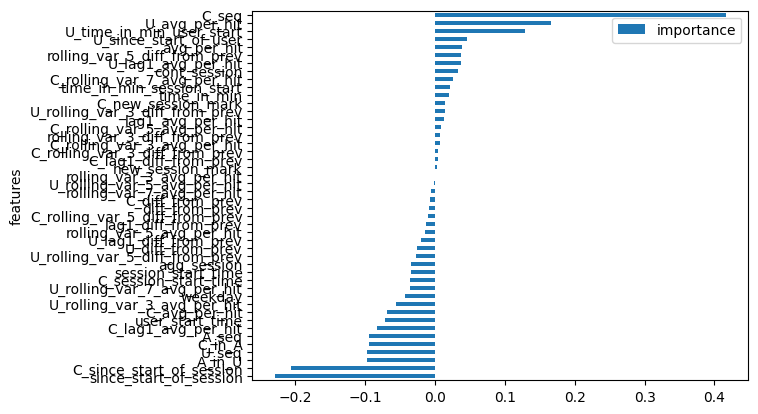

In [523]:
df_feature_importance.to_pandas().plot.barh(x='features', y='importance');

In [524]:
df_feature_importance.shape

(46, 2)

In [525]:
df_feature_importance.filter(pl.col('importance').abs() > 0.02)

features,importance
str,f64
"""since_start_of_session""",-0.229183
"""C_since_start_of_session""",-0.206288
"""A_in_U""",-0.096724
"""U_seq""",-0.096724
"""C_in_A""",-0.094728
…,…
"""avg_per_hit""",0.038757
"""U_since_start_of_user""",0.045042
"""U_time_in_min_user_start""",0.129214


In [534]:
final_model = make_pipeline(
    StandardScaler(),
    # lightgbm.LGBMClassifier(random_state=1, n_estimators=20, class_weight={0: 1, 1: 1}),
    # RandomForestClassifier(random_state=1, n_estimators=100),
    # GradientBoostingClassifier(random_state=1)
    LogisticRegression(),
)

In [547]:
selected_features = df_feature_importance.filter(pl.col('importance').abs() > 0.02)['features']
# selected_features = features

In [548]:
final_model.fit(df.filter(train_index)[selected_features], df['target'].filter(train_index))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [549]:
predictions = final_model.predict_proba(df.filter(test_index)[selected_features])

In [550]:
accuracy_score(df['target'].filter(test_index), predictions[:,1] > 0.5)

0.6681053430843624

In [551]:
roc_auc_score(df['target'].filter(test_index), predictions[:,1])

0.6169120111000193

In [552]:
cm = confusion_matrix(df['target'].filter(test_index), predictions[:,1] > 0.5)

# plt.matshow(cm)
# plt.colorbar()
# plt.show()

In [553]:
cm

array([[16204,   764],
       [ 7541,   514]])